In [1]:
import igra
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from metpy import calc, units
# using igra to do this! https://pypi.org/project/igra/

In [2]:
def get_igra_data(station, name):
    """
    Fetch IGRA data for a given station.
    
    Parameters:
    station (str): The station ID to fetch data for.
    
    Returns:
    xarray.Dataset: The dataset containing IGRA data.
    """
    station_data = igra.download.station(station, f"./01_data/raw_data/{name}_radiosonde",)
    data, station = igra.read.igra(station, f"./01_data/raw_data/{name}_radiosonde/{station}-data.txt.zip", levels=np.arange(50000, 100000,1000))
    # using windd and winds, calculate u and v
    data["u"] = data["winds"] * np.cos(np.deg2rad(270-data["windd"]))   
    data["v"] = data["winds"] * np.sin(np.deg2rad(270-data["windd"]))

    # calculate specific humidity from relative humidity and temperature and pressure
    data["dew_point"] = calc.dewpoint_from_relative_humidity(data["temp"]*units.units.K, data["rhumi"]).metpy.dequantify()
    data["q"] = (calc.specific_humidity_from_dewpoint(data["pres"], data["dew_point"])*units.units("kg/kg")*1000*units.units("g/kg")).metpy.dequantify()

    data['temp'] = (data['temp']*units.units.K).metpy.convert_units('degC')  # Convert from Kelvin to Celsius

    return data

sites = {
    "Quillayute": "USM00072797",
    "Salem":"USM00072694",
    "Grand_Junction": "USM00072476",
    "Spokane": "USM00072786 "
}

quillayute_sounding_ds = get_igra_data(sites["Quillayute"], "Quillayute")
salem_sounding_ds = get_igra_data(sites["Salem"], "Salem")



https://www1.ncdc.noaa.gov/pub/data/igra/data/data-por//USM00072797-data.txt.zip  to  ./01_data/raw_data/Quillayute_radiosonde/USM00072797-data.txt.zip
Downloaded:  ./01_data/raw_data/Quillayute_radiosonde/USM00072797-data.txt.zip


/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/igra/read.py:158: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



https://www1.ncdc.noaa.gov/pub/data/igra/data/data-por//USM00072694-data.txt.zip  to  ./01_data/raw_data/Salem_radiosonde/USM00072694-data.txt.zip
Downloaded:  ./01_data/raw_data/Salem_radiosonde/USM00072694-data.txt.zip


/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/igra/read.py:158: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [3]:
def find_nearest_freezing_lvl(ds):
    """
    Find the height (hPa) index of the nearest freezing level in the dataset.
"""
    # identify the geopotential height where the temperature is closest to 0
    # adds in the absolute minumum temperature
    ds['absolute_temp'] = ds.apply(np.fabs)['temp']

    # filter to only days where the absolute min is less than 0.5 degrees C
    filter_temp = ds['absolute_temp'].metpy.magnitude < 1
    pres_filter = ds['absolute_temp'].where(filter_temp).idxmin(dim='pres')
    # filter the dataset to only include the filtered data
    ds_filtered = ds.sel(pres=pres_filter, method='nearest')
    winter_data_only = ds_filtered.where(ds_filtered['date.month'].isin([12, 1, 2, 3]), drop=True)
    return winter_data_only

# develop some tests
def test_find_nearest_freezing_lvl():
    """
    Test the find_nearest_freezing_lvl function.
    """
    # Create a sample dataset
    data = xr.Dataset(
                    data_vars={
                        'temp': (['pres', 'date'], [[-0.05, 0, 0, 1, -0.05], [0, 0.05, -1, 0, 0]]),
                        'gph': (['pres', 'date'], [[1000, 900, 900, 1300, 1400], [900, 1000, 1100, 900, 900]]),
                        'pres': (['pres'], [1000, 900]),
                        'date': (['date'], pd.date_range('2023-01-01', periods=5)),
                    }
                )
    
    result = find_nearest_freezing_lvl(data)
    
    # Check if the result is as expected
    print(result)
    assert result['temp'].values[0] == 0, "Freezing level temperature should be close to 0"
    assert result['gph'].values[0] == 900, "Freezing level pressure should be close to 1000 hPa"

# Run the test
test_find_nearest_freezing_lvl()

<xarray.Dataset>
Dimensions:        (date: 5)
Coordinates:
    pres           (date) int64 900 1000 1000 900 900
  * date           (date) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-01-05
Data variables:
    temp           (date) float64 0.0 0.0 0.0 0.0 0.0
    gph            (date) float64 900.0 900.0 900.0 900.0 900.0
    absolute_temp  (date) float64 0.0 0.0 0.0 0.0 0.0


In [4]:
# test case. select one day and check
test_ds = quillayute_sounding_ds.sel(date='2023-10-10 00')
# filter to only days where the absolute min is less than 0.5 degrees C
filter_temp = test_ds['absolute_temp'].metpy.magnitude < 1
pres_filter = test_ds['absolute_temp'].where(filter_temp).idxmin(dim='pres')
test_ds.plot.scatter(x='absolute_temp',y='gph')
# plot a line at the freezing level
plt.axhline(y=test_ds.sel(pres=pres_filter, method='nearest')['gph'], color='r', linestyle='--', label='Freezing Level')
# add text of what that level is
plt.text(10, test_ds.sel(pres=pres_filter, method='nearest')['gph']+50, f"Freezing Level: {np.round(test_ds.sel(pres=pres_filter, method='nearest')['gph'].values, 0)}m", color='red')

KeyError: 'absolute_temp'

In [ ]:
quillayute_winter_data = find_nearest_freezing_lvl(quillayute_sounding_ds)
quillayute_winter_freezing_levels = quillayute_winter_data['gph'].metpy.convert_units('ft').to_dataframe()  # Convert geopotential height to meters
quillayute_winter_freezing_levels['water_year'] = quillayute_winter_freezing_levels.index.year + (quillayute_winter_freezing_levels.index.month >= 10).astype(int)  # Define water year starting in October

# do the same for salem
salem_winter_data = find_nearest_freezing_lvl(salem_sounding_ds)
salem_winter_freezing_levels = salem_winter_data['gph'].metpy.convert_units('ft').to_dataframe()  # Convert geopotential height to meters
salem_winter_freezing_levels['water_year'] = salem_winter_freezing_levels.index.year + (salem_winter_freezing_levels.index.month >= 10).astype(int)  # Define water year starting in October


In [ ]:
salem_winter_freezing_levels.to_csv("./01_data/processed_data/salem_winter_freezing_levels.csv")
quillayute_winter_freezing_levels.to_csv("./01_data/processed_data/quillayute_winter_freezing_levels.csv")

In [ ]:
# import loess smoothing
from statsmodels.nonparametric.smoothers_lowess import lowess
def smooth_data(data, frac=0.1):
    """
    Smooth the data using LOESS smoothing.
    
    Parameters:
    data (pd.Series): The data to smooth.
    frac (float): The fraction of the data used for smoothing.
    
    Returns:
    pd.Series: The smoothed data.
    """
    smoothed = lowess(data, np.arange(len(data)), frac=frac)
    return pd.Series(smoothed[:, 1], index=data.index)

Text(0.05, 0.95, 'Quillayute Trend: increasing, p-value: 0.02\nSalem Trend: no trend, p-value= 0.25')

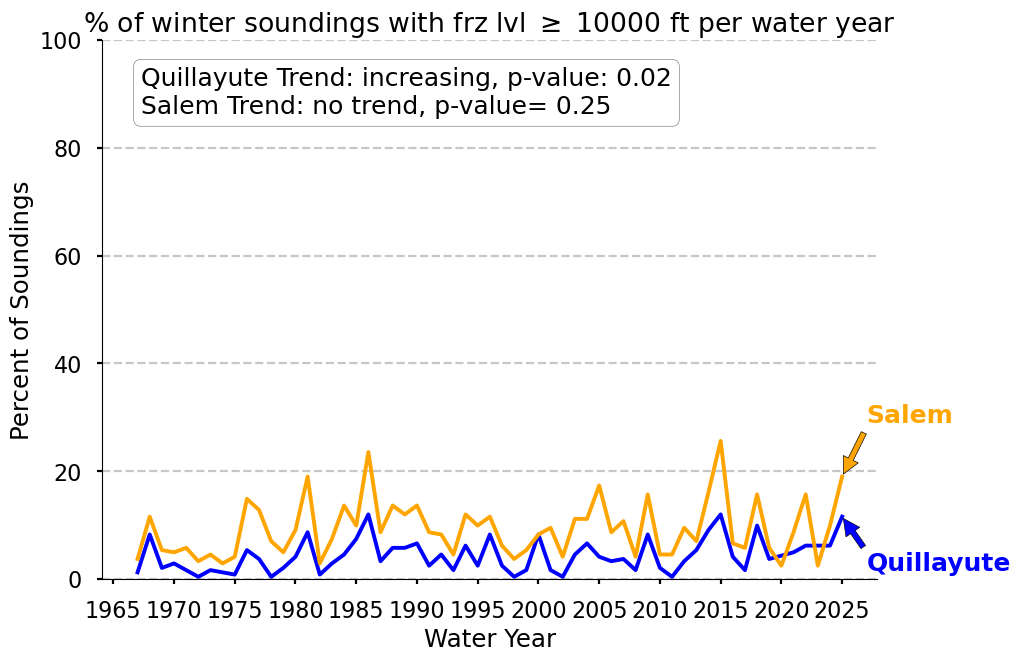

In [ ]:
plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(10, 7))
years = slice(1967,2025)
level_of_interest = 10000  # feet
number_of_soundings = (31+31+28+31)*2
# plot quillayute
quillayute_plot_data = (100*quillayute_winter_freezing_levels[quillayute_winter_freezing_levels['gph']>=level_of_interest].groupby('water_year').count()['gph'].loc[1967:2025]/number_of_soundings)
quillayute_plot_data.plot(ax=ax, color='blue')
# plot a smooth version of the data
# quillayute_plot_data_smooth = smooth_data(quillayute_plot_data, frac=0.3)
# quillayute_plot_data_smooth.plot(ax=ax, color='blue', linestyle='--', linewidth=2, alpha=0.7)
# add salem
salem_plot_data = (100*salem_winter_freezing_levels[salem_winter_freezing_levels['gph']>=level_of_interest].groupby('water_year').count()['gph'].loc[1967:2025]/number_of_soundings)
salem_plot_data.plot(ax=ax, color='orange')
# plot a 5-year moving average of the data
salem_plot_data.rolling
# set the title and labels
ax.set_title(f'% of winter soundings with frz lvl $\geq$ {level_of_interest} ft per water year')
ax.set_xlabel('Water Year')
ax.set_ylabel('Percent of Soundings')
ax.set_ylim(0, 100)

ax.set_xticks(np.arange(1965, 2026, 5));
# ax.set_xticklabels(np.arange(1965, 2026, 5), rotation=30, va='center', ha='center')
ax.grid(axis='y', linestyle='--', alpha=0.7)
# turn off top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# label the line
ax.annotate("Quillayute", xy=(2025, quillayute_plot_data.iloc[-1]), 
            xytext=(2027, quillayute_plot_data.iloc[-1]-10),
            arrowprops=dict(facecolor='blue', shrink=0.05),
            fontsize=18, color='blue',fontweight='bold')
ax.annotate("Salem", xy=(2025, salem_plot_data.iloc[-1]),
            xytext=(2027, salem_plot_data.iloc[-1]+10),
            arrowprops=dict(facecolor='orange', shrink=0.05),
            fontsize=18, color='orange', fontweight='bold')

import pymannkendall as mk
# Perform Mann-Kendall trend test
quillayute_trend = mk.original_test(quillayute_winter_freezing_levels[quillayute_winter_freezing_levels['gph']>=level_of_interest].groupby('water_year').count()['gph'])
salem_trend = mk.original_test(salem_winter_freezing_levels[salem_winter_freezing_levels['gph']>=level_of_interest].groupby('water_year').count()['gph'].loc[1967:2025])

# add the trend to the plot
ax.text(0.05, 0.95, f"Quillayute Trend: {quillayute_trend.trend}, p-value: {round(quillayute_trend.p,2)}\nSalem Trend: {salem_trend.trend}, p-value= {round(salem_trend.p,2)}",
        transform=ax.transAxes, fontsize=18, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
# Show the plot


Quillayute Trend: Mann_Kendall_Test(trend='no trend', h=False, p=0.28038537899383753, z=-1.0794540235497228, Tau=-0.09701928696668614, s=-166.0, var_s=23364.666666666668, slope=-0.30303030303030304, intercept=75.78787878787878)
Salem Trend: Mann_Kendall_Test(trend='no trend', h=False, p=0.19964540028445077, z=-1.2825624854826527, Tau=-0.11513734658094682, s=-197.0, var_s=23353.666666666668, slope=-0.18181818181818182, intercept=50.27272727272727)
